In [ ]:
"""
Interpretation and exploration of topic modeling (NMF with TF-IDF)
The 8 topics are:
1. Family & friends
2. Women's voice
3. New generation & nation
4. Tech & business
5. Hardship
6. Sportsmanship
7. Arts & science
8. Dream

- Examine topic distribution for 3 geographic regions (west,central,east)
- Examine topic distribution for different professions



"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

from wordcloud import WordCloud

from gensim import matutils, models
import scipy.sparse

import re
import string

import nltk
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline


%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/katiehuang/Documents/metis/projects/onl_ds5_project_4/py')
from word_cloud import *
from clean import *
import importlib

In [2]:
# Let's read in our transcripts and document-term matrix
speech_df_raw = pd.read_pickle('../dump/speech_df')
speech_df = pd.read_pickle('../dump/speech_clean_lemma')
speech_concise = pd.read_pickle('../dump/speech_concise')

## 1. Acquire the topics from topic modeling

The function `topic_modeling(speech_df_x,column_name,num_topic)` is in the python script clean.py.  
* Input: df and column_name (e.g.: 'transcript' for all text, `nouns` for nouns only)  
* Process: TF-IDF and NMF  
* Output: topic-term matrix (dataframe)

In [3]:
def topic_modeling(speech_df_x,column_name,num_topic):
    """
    For a given df and column_name (e.g.:'transcript' for all text, 'nouns' for nouns only),
    return the topic_word dataframe
    
    Method: Tf-idf and NMF
    
    """
    
    # Prepare Tf-idf
    tfidf = TfidfVectorizer()
    csr_mat = tfidf.fit_transform(speech_df_x[column_name])
    doc_word = tfidf_dtm(speech_df_x,column_name)

    # Modeling
    nmf_model = NMF(num_topic, max_iter=1000, random_state=28)
    doc_topic = nmf_model.fit_transform(doc_word)
    doc_assigned_topic = doc_topic.argsort(axis=1)[:,-1]

    # Use components in NMF model to find the top 10 words for a given topic
    topics = nmf_model.components_.argsort(axis=1)[:,-1:-21:-1]

    # Create topic_worrd df
    words = doc_word.columns
    topic_words = [[words[index] for index in topic] for topic in topics]
    topic_word_df = pd.DataFrame(topic_words,index=['Topic #' + '{:02d}'.format(i+1) for i in range(num_topic)])
    
    return topic_word_df

In [4]:
# First use the topic model on all transcripts

num_topic = 8
speech_df_x = wash(speech_concise,'transcript').copy()
topic_df = topic_modeling(speech_df_x,'nouns',num_topic)
topic_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Topic #01,parent,advice,film,story,money,friends,kid,person,movie,play,man,moment,actor,year,home,point,night,room,days,course
Topic #02,women,workers,voice,genius,floor,success,conversation,mother,workforce,skirt,gender,book,silence,privilege,fact,doors,connection,factory,place,balance
Topic #03,generation,country,government,community,education,history,nation,nations,century,freedom,sense,democracy,challenge,change,society,percent,purpose,culture,future,war
Topic #04,company,business,journey,career,passion,technology,selfconfidence,leadership,confidence,engineer,decision,success,path,law,courage,purpose,heart,ideas,customers,family
Topic #05,fear,generosity,hearts,drum,heart,truth,moment,mind,practice,death,music,failure,value,experience,virtue,power,sound,compassion,joy,flow
Topic #06,team,tennis,sport,game,player,coach,baseball,dream,soccer,percent,football,mentor,players,cookie,ball,numberone,friendships,cents,women,honorees
Topic #07,art,science,book,paint,artist,shell,scientist,course,botany,seashells,genus,perception,garden,species,study,materials,wholebrain,pepper,literature,research
Topic #08,dream,education,mother,father,degree,family,thank,community,sister,value,opportunity,core,parent,advice,speech,share,student,doctor,heart,doctorate


In [5]:
# # Pickle
# # This it the topic modeling used in slides

# topic_df.to_pickle('../dump2/topic_df_8_NMF')

Interpretation of topics:

1. Family & friends
2. Women's voice
3. New generation & nation
4. Tech & business
5. Hardship
6. Sportsmanship
7. Arts & science
8. Dream

In [6]:
# # Trial (added stop words in clean.py)
# # Does not change much; commented out the added stop words in clean.py

# num_topic = 8
# speech_df_x = wash(speech_concise,'transcript').copy()
# topic_df = topic_modeling(speech_df_x,'nouns',num_topic)
# topic_df

## 2. Add topic found to the DataFrame
Create a new column in speech_df_x for the assigned topic.

In [7]:
# Find assigned_topic

tfidf = TfidfVectorizer()
csr_mat = tfidf.fit_transform(speech_df_x['nouns'])
doc_word = tfidf_dtm(speech_df_x,'nouns')

# Modeling
nmf_model = NMF(num_topic, max_iter=1000)
doc_topic = nmf_model.fit_transform(doc_word)

# Array of assigned topic
doc_assigned_topic = doc_topic.argsort(axis=1)[:,-1]+1

In [8]:
# Create column for topic
speech_df_x['topic'] = doc_assigned_topic

In [9]:
# Map the topic (nuemrical) to text for interpretation later
# Store in new column 'TOPIC'
mapping_topic = {'1':'1 Family','2':"2 Women",'3':'3 Nation','4':"4 Tech",
                 '5':"5 Hardship",'6':"6 Sports",'7':"7 Science",'8':"8 Dream"}
speech_df_x['TOPIC'] = speech_df_x['topic'].astype(str).map(mapping_topic)

In [10]:
speech_df_x.head()

,speaker,year,school,transcript,transcript_clean,category,age,age_then,age_cat,region,nouns,topic,TOPIC
0,CARLY FIORINA,2000,MIT,like to start my remark this morning with spec...,I'd start remarks morning special thanks sent ...,Tech/Business,66,46,40-50,east,remark morning thank couple weeks speech comme...,5,5 Hardship
1,J.K. ROWLING,2008,Harvard University,i have wrack my mind and heart for what i ough...,"EXCERPTS Actually, I wracked mind heart I ough...",Publish,55,43,40-50,east,i mind heart i today i i graduation lessons ye...,5,5 Hardship
2,JEAN ANDREWS,2003,University of Texas at Austin,when invite me to present the commencement add...,\nWhen Dean Rankin invited present commencemen...,Education/Research,97,80,80-90,central,commencement address class graduate i anyone y...,7,7 Science
3,MIKE TOMLIN,2008,Saint Vincent College,some excerpt as find in want to encourage you ...,"Some excerpts Post Gazette:\n\n ""I encourag...",Sport,48,36,30-40,east,excerpt find want preparation game life minute...,4,4 Tech
4,AARON SORKIN,2012,SYRACUSE UNIVERSITY,you very much members of the of members of the...,"Thank much. Madam Chancellor, members Board T...",Publish,59,51,50-60,east,members members faculty administration parent ...,1,1 Family


In [11]:
# # Pickle
# speech_df_x.to_pickle('../dump/speech_topic_NMF')

### Trend of topic over the years

In [12]:
topic_year = []
for i in range(num_topic):
    topic_year.append(speech_df_x[speech_df_x.topic == i+1].sort_values('year').year.value_counts().sort_index())

In [13]:
topic_yeat_df = pd.DataFrame(topic_year,index=[i+1 for i in range(num_topic)]).fillna(0)
topic_yeat_df_T = topic_yeat_df.loc[:,2000:].transpose()
topic_yeat_df_T['9']=[0]*topic_yeat_df_T.shape[0]       # just for adjusting the colormap later
# topic_yeat_df_T

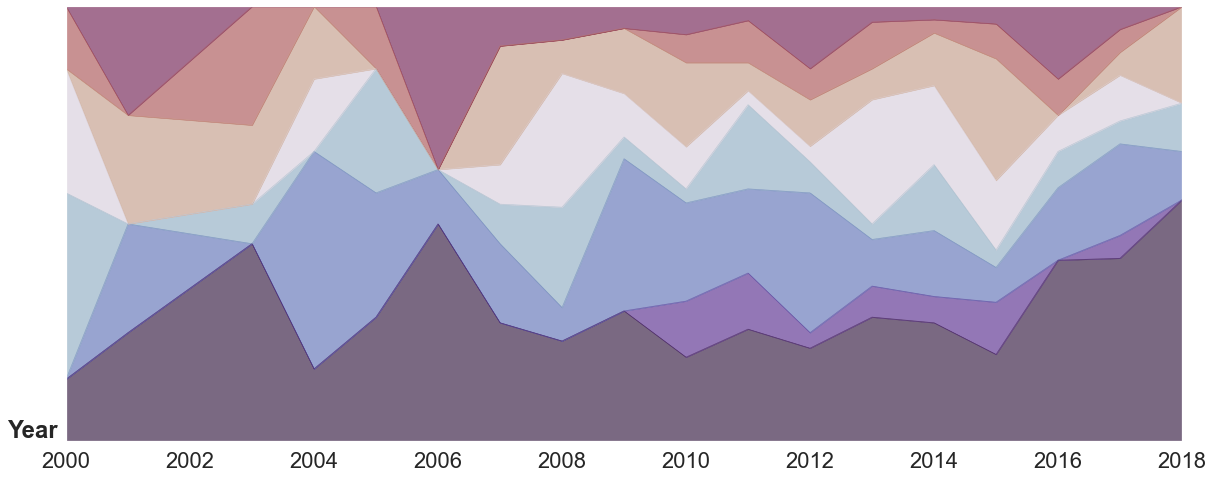

In [14]:
# Full stack area plot

plt.rcParams['figure.figsize']=[20,8]
cmap = plt.get_cmap('twilight_shifted')

df = topic_yeat_df_T.divide(topic_yeat_df_T.sum(axis=1), axis=0)
ax = df.plot(kind='area', stacked=True, alpha = 0.6, cmap = cmap,
             linewidth=0.5, legend=False,
            )

ax.set_ylabel('Percent (%)')
ax.margins(0, 0) # Set margins to avoid "whitespace"
# plt.legend(bbox_to_anchor=(1., 1))
plt.ylim(0,1)
ax.grid(False)
ax.axes.yaxis.set_ticks([])
# ax.set_title('Trend of topic over the years',fontsize=28)
ax.set_ylabel('',fontsize=18)
ax.set_xlabel('Year',fontsize=24,fontweight='bold')
plt.xticks(fontsize=22)
plt.yticks(fontsize=14)

ax.xaxis.set_label_coords(-0.03, 0.05)

plt.show()

fig = ax.get_figure()
# fig.savefig('../plot/topic_trend.pdf', bbox_inches='tight', transparent = True)

# 1. Family, friends & advice
# 2. Women's voice
# 3. New generation & the nation
# 4. Dream & value
# 5. Fear & truth
# 6. Sports & team player
# 7. Art & science
# 8. Technology & business

In [15]:
# # RGB of the colors
# 135, 122, 150
# 137, 67, 186
# 158, 181, 219
# 155, 194, 190
# 227, 223, 213
# 214, 188, 159
# 189, 130, 143
# 161, 112, 148

## 3. Topic distribution

### A. All speeches

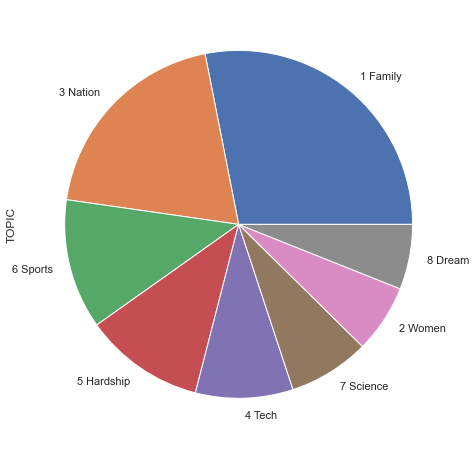

In [16]:
# Check topic distribution over time
dist_df = speech_df_x.TOPIC.value_counts()
dist_df.plot.pie(y='TOPIC');

### B. Distribution by regions

In [17]:
# Number of speeches in 3 regions
speech_df_x.region.value_counts()

east       241
west        47
central     43
Name: region, dtype: int64

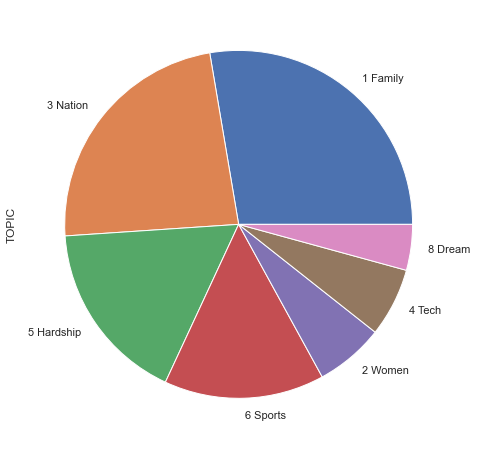

In [18]:
# West
west_topic = speech_df_x[(speech_df_x.region == 'west')].TOPIC.value_counts()
west_topic.plot.pie(y='TOPIC');

In [19]:
west_topic.reset_index().rename(columns={'index':'topic','TOPIC':'count'}).sort_values('topic').reset_index(drop=True)
# Missing #7 (Arts&Science)

,topic,count
0,1 Family,13
1,2 Women,3
2,3 Nation,11
3,4 Tech,3
4,5 Hardship,8
5,6 Sports,7
6,8 Dream,2


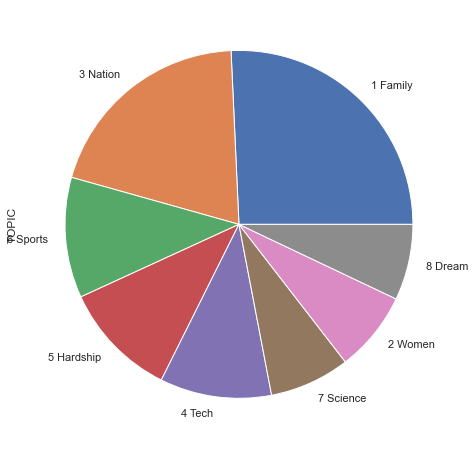

In [20]:
# East
east_topic = pd.DataFrame(speech_df_x[(speech_df_x.region == 'east')].TOPIC.value_counts())
east_topic.plot.pie(y='TOPIC',legend=False);

In [21]:
east_topic.reset_index().rename(columns={'index':'topic','TOPIC':'count'}).sort_values('topic').reset_index(drop=True)

,topic,count
0,1 Family,62
1,2 Women,18
2,3 Nation,48
3,4 Tech,25
4,5 Hardship,26
5,6 Sports,27
6,7 Science,18
7,8 Dream,17


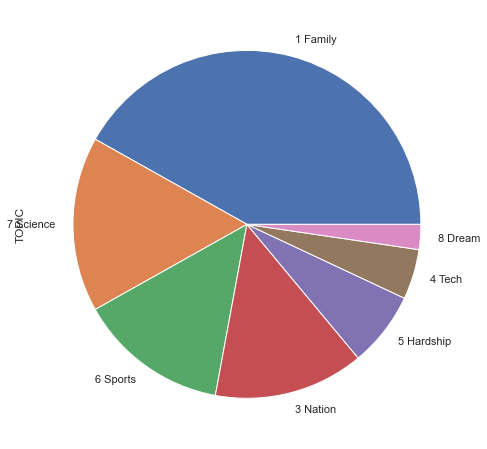

In [22]:
# Central
central_topic = speech_df_x[(speech_df_x.region == 'central')].TOPIC.value_counts()
central_topic.plot.pie(y='TOPIC');

In [23]:
central_topic.reset_index().rename(columns={'index':'topic','TOPIC':'count'}).sort_values('topic').reset_index(drop=True)
# Missing #2 (Women's voice)

,topic,count
0,1 Family,18
1,3 Nation,6
2,4 Tech,2
3,5 Hardship,3
4,6 Sports,6
5,7 Science,7
6,8 Dream,1


### C. Distribution by speaker's profession 

In [24]:
# Pull out the profession categories
speech_df_x.category.unique()

array(['Tech/Business', 'Publish', 'Education/Research', 'Sport',
       'Entertainment', 'Politics', 'Med/Law', 'Science', 'Art', 'Other'],
      dtype=object)

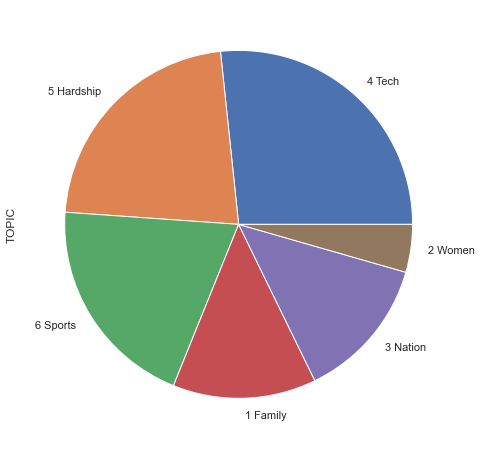

In [25]:
# Tech/Business
east_topic = speech_df_x[(speech_df_x.category == 'Tech/Business')].TOPIC.value_counts()
east_topic.plot.pie(y='TOPIC');

May be interesting ...

* Tech/Business --> Dream/fear,failure/generation
* Publish --> women's voice
* Education/Research --> generation/ art,science / dream
* Sport --> tech,business / sportsmanship / dream
* Entertainment --> sportsmanship / fear
* politics --> generation,nation / dream / sportsmanship
* art --> fear / arts & science / 

In [26]:
# Create DataFrame
speech_df_x.groupby(['category','TOPIC']).count()

speaker  year  school  transcript  \
category           TOPIC                                           
Art                1 Family          2     2       2           2   
                   3 Nation          1     1       1           1   
                   5 Hardship        1     1       1           1   
                   6 Sports          1     1       1           1   
                   7 Science         3     3       3           3   
Education/Research 1 Family          2     2       2           2   
                   3 Nation          8     8       8           8   
                   7 Science         2     2       2           2   
                   8 Dream           1     1       1           1   
Entertainment      1 Family         45    45      45          45   
                   2 Women           4     4       4           4   
                   3 Nation          9     9       9           9   
                   4 Tech            2     2       2           2   
                   5 Hardship       11    11      11          11   
                   6 Sports         15    15      15          15   
                   7 Science         7     7       7           7   
                   8 Dream           5     5       5           5   
Med/Law            1 Family          3     3       3           3   
                   3 Nation          2     2       2           2   
                   4 Tech            1     1       1           1   
                   5 Hardship        2     2       2           2   
                   6 Sports          3     3       3           3   
Other              1 Family          1     1       1           1   
                   3 Nation          1     1       1           1   
Politics           1 Family          6     6       6           6   
                   2 Women           1     1       1           1   
                   3 Nation         17    17      17          17   
                   5 Hardship        2     2       2           2   
                   6 Sports          3     3       3           3   
                   8 Dream           7     7       7           7   
Publish            1 Family         26    26      26          26   
                   2 Women          14    14      14          14   
                   3 Nation         17    17      17          17   
                   4 Tech            4     4       4           4   
                   5 Hardship        9     9       9           9   
                   6 Sports          4     4       4           4   
                   7 Science         9     9       9           9   
                   8 Dream           5     5       5           5   
Science            1 Family          1     1       1           1   
                   3 Nation          3     3       3           3   
                   6 Sports          3     3       3           3   
                   7 Science         2     2       2           2   
Sport              1 Family          1     1       1           1   
                   3 Nation          1     1       1           1   
                   4 Tech           11    11      11          11   
                   5 Hardship        2     2       2           2   
                   6 Sports          2     2       2           2   
                   7 Science         2     2       2           2   
                   8 Dream           2     2       2           2   
Tech/Business      1 Family          6     6       6           6   
                   2 Women           2     2       2           2   
                   3 Nation          6     6       6           6   
                   4 Tech           12    12      12          12   
                   5 Hardship       10    10      10          10   
                   6 Sports          9     9       9           9   

                               transcript_clean  age  age_then  age_cat  \
category           TOPIC                                                  
Art 